### What is Gradiant Boosting?
Gradient boosting is the optimization of a loss function by adding weak learners. Adaboost is an example of a famous gradiant boosting algorithm. Gradient boosting is comprised of three components.

+ A loss function to optimize
+ A weak learning algorithm
+ An additive model

New weak learners are added to the model to correct for residual errors of previous learners



### What is XGBoost?
XGboost is a gradiant boosting algorithm that uses decision trees. Traditional gradiant boosting algorithmns are slow because of the sequential nature of the additive model. XGBoost implements distributed computing and parallelization to speed and distribute the process across hardware.


In [9]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


seeds = loadtxt('data/seeds_dataset.txt', delimiter='\t')

In [10]:
# Split the data into matix and response
X = seeds[:,0:6]
Y = seeds[:,7]

In [11]:
# Train Test Split
seed = 7
test_size = 0.30
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=test_size, random_state=seed)

In [12]:
model = XGBClassifier()
model.fit(Xtrain,Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [13]:
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [14]:
accuracy = accuracy_score(Ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 87.30%


## Adding Early Stopping

Why add early stopping to limit the number of added models when the improvement on the validation set is stagnant

In [17]:
model = XGBClassifier()
eval_set = [(Xtest, Ytest)]
model.fit(Xtrain,Ytrain, early_stopping_rounds=10, eval_metric="mlogloss",eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:0.991322
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.901136
[2]	validation_0-mlogloss:0.824736
[3]	validation_0-mlogloss:0.758384
[4]	validation_0-mlogloss:0.696645
[5]	validation_0-mlogloss:0.64579
[6]	validation_0-mlogloss:0.599396
[7]	validation_0-mlogloss:0.560468
[8]	validation_0-mlogloss:0.524656
[9]	validation_0-mlogloss:0.495259
[10]	validation_0-mlogloss:0.468132
[11]	validation_0-mlogloss:0.444329
[12]	validation_0-mlogloss:0.419029
[13]	validation_0-mlogloss:0.396437
[14]	validation_0-mlogloss:0.376703
[15]	validation_0-mlogloss:0.360419
[16]	validation_0-mlogloss:0.344193
[17]	validation_0-mlogloss:0.332595
[18]	validation_0-mlogloss:0.319433
[19]	validation_0-mlogloss:0.308658
[20]	validation_0-mlogloss:0.301146
[21]	validation_0-mlogloss:0.292714
[22]	validation_0-mlogloss:0.287553
[23]	validation_0-mlogloss:0.277096
[24]	validation_0-mlogloss:0.271158
[25]	validation_0-mlogloss:0.265957
[26]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
## Make predictions on model and compare to test response
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 87.30%


### Feature Importance Using XGBoost

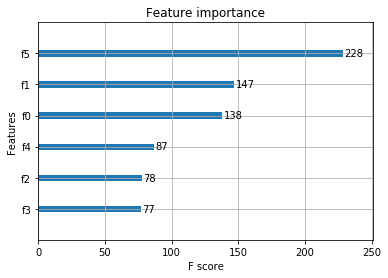

In [23]:
from matplotlib import pyplot
xgboost.plot_importance(model)
pyplot.show()

### Configure Gradiant Boosting

+ learning rate
+ depth of trees
+ row sampling

Set the number of trees to a target value of 100 or 1000, then tune the learning rate to find the best model. 

1. Run the default configuration and review plots of the learning curves on the training and validation datasets.
2. If the system is overlearning, decrease the learning rate and/or increase the number of trees.
3. If the system is underlearning, speed the learning up to be more aggressive by increasing the learning rate and/or decreasing the number of trees.

### Tuning XGBoost Hyperparameters

In [24]:
n_estimators = [50, 100, 150, 200]
max_depth = [2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=1, cv=kfold, verbose=1)
result = grid_search.fit(X, Y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    6.5s finished


In [28]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -0.261119 using {'n_estimators': 50, 'max_depth': 2}


In [31]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
   # print("%f (%f) with: %r" % (mean, stdev, param))

### Test Improvement of Model with optimized parameters

In [33]:
model = XGBClassifier(n_estimators=50, max_depth=2)
model.fit(Xtrain,Ytrain, early_stopping_rounds=10, eval_metric="mlogloss",eval_set=eval_set, verbose=True)


## Make predictions on model and compare to test response
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

[0]	validation_0-mlogloss:0.995903
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.908406
[2]	validation_0-mlogloss:0.83178
[3]	validation_0-mlogloss:0.765453
[4]	validation_0-mlogloss:0.708349
[5]	validation_0-mlogloss:0.657645
[6]	validation_0-mlogloss:0.611872
[7]	validation_0-mlogloss:0.573916
[8]	validation_0-mlogloss:0.537774
[9]	validation_0-mlogloss:0.507919
[10]	validation_0-mlogloss:0.479049
[11]	validation_0-mlogloss:0.455235
[12]	validation_0-mlogloss:0.434331
[13]	validation_0-mlogloss:0.415722
[14]	validation_0-mlogloss:0.398217
[15]	validation_0-mlogloss:0.381415
[16]	validation_0-mlogloss:0.366371
[17]	validation_0-mlogloss:0.352855
[18]	validation_0-mlogloss:0.340776
[19]	validation_0-mlogloss:0.32966
[20]	validation_0-mlogloss:0.321302
[21]	validation_0-mlogloss:0.312144
[22]	validation_0-mlogloss:0.301412
[23]	validation_0-mlogloss:0.291351
[24]	validation_0-mlogloss:0.285851
[25]	validation_0-mlogloss:0.277192
[26]	va

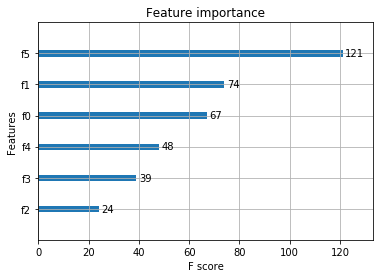

In [34]:
xgboost.plot_importance(model)
pyplot.show()

### Configure learning rate with GridSearch

In [35]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 100, 150, 200]
max_depth = [2,4,6,8]
param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
result = grid_search.fit(X, Y)

In [ ]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))